In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from datetime import datetime
import io
import csv
import shutil
import matplotlib.pyplot as plt

year = 2017
YEAR_FLAG = 'train'
img_folder = '/datadrive/timelapse_images_fast'
timeseries_folder = '/datadrive/timeseries_derived_data_products_'+str(year)
target_folder_train = '/datadrive/train_data'
target_folder_test = '/datadrive/test_data'
year_path = [(year, img_folder)]#] for y in range(2011, 2018)]

In [24]:
df = pd.DataFrame()
for y, _ in year_path:
    path = os.path.join(timeseries_folder,'MH11_resistivity_rock_{}.csv'.format(y))
    df = pd.concat((df, pd.read_csv(path)), axis=0)
    
df2 = pd.DataFrame()
for y, _ in year_path:
    path2 = os.path.join(timeseries_folder,'MH25_vaisalawxt520prec_{}.csv'.format(y))
    df2 = pd.concat((df2, pd.read_csv(path2)), axis=0)
    
df3 = pd.DataFrame()
for y, _ in year_path:
    path3 = os.path.join(timeseries_folder,'MH25_vaisalawxt520windpth_2017.csv'.format(y))
    df3 = pd.concat((df3, pd.read_csv(path3)), axis=0)

In [28]:
def interpolate_to_timestamps(df, time_stamps):
    df = df.resample('4T').interpolate()
    ind = [df.index.get_loc(tim, method='nearest') for tim in time_stamps.time]
    return df.iloc[ind, :]
def extract_time_stamps(year_path):
    """
    input: [(year, root_dir), ...]
    """
    dfs = pd.DataFrame()
    for y, root_dir in year_path:
        path_dict = {}
        for filename in glob.iglob(root_dir + '**/'+str(y)+'*/*', recursive=True):
            di, filname = os.path.split(filename)
            ddi, ydi = os.path.split(di)
            path_dict[filname] = extract_time(filname)
        df = pd.DataFrame({'time':list(path_dict.values()), 'filename': list(path_dict.keys())}, )
        dfs = pd.concat((dfs, df), axis=0)
    return dfs

def extract_time(filname):
    return datetime.strptime(filname, '%Y%m%d_%H%M%S.JPG')

def extract_summer_days(time_stamps):
    start = pd.Timestamp(datetime(year=2000, month=1, day=1, hour=8)).time()
    end = pd.Timestamp(datetime(year=2000, month=1, day=1, hour=20)).time()
    time_stamps_day = time_stamps[np.logical_and(time_stamps['time'].dt.time >= start , 
                                                 time_stamps['time'].dt.time <= end)]
    
    june = pd.Timestamp(datetime(year=2000, month=5, day=1, hour=8)).month
    august = pd.Timestamp(datetime(year=2000, month=8, day=1, hour=8)).month

    time_stamps_summerday = time_stamps_day[np.logical_and(time_stamps['time'].dt.month < august , 
                                                           time_stamps['time'].dt.month >= june)]
    
    return time_stamps_summerday


In [31]:
#time_stamps = pd.read_pickle('pd_time_stamps.pkl')
#time_stamps.head()
time_stamps = extract_time_stamps(year_path)
summer_days = extract_summer_days(time_stamps)

/home/ivan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


,time,filename
0,2017-10-28 02:48:10,20171028_024810.JPG
1,2017-10-28 04:48:11,20171028_044811.JPG
2,2017-10-28 13:40:10,20171028_134010.JPG
3,2017-10-28 10:12:11,20171028_101211.JPG
4,2017-10-28 23:28:10,20171028_232810.JPG


In [33]:
df = df.set_index(pd.DatetimeIndex(df.loc[:, 'time']))
df_interp = interpolate_to_timestamps(df, summer_days)
df2 = df2.set_index(pd.DatetimeIndex(df2.loc[:, 'time']))
df2_interp = interpolate_to_timestamps(df2, summer_days)
df_interp['path'] = summer_days.filename.values

df_interp['label_thresh_rest10_1'] = df_interp.loc[:, 'resistivity_10cm [Mohm]'] < 300
df_interp['label_thresh_rest10_2'] = np.logical_and(300 < df_interp.loc[:, 'resistivity_10cm [Mohm]'],
                                                    df_interp.loc[:, 'resistivity_10cm [Mohm]'] < 1200)
df_interp['label_thresh_rest10_3'] = 1200 < df_interp.loc[:, 'resistivity_10cm [Mohm]']
df_interp['label_thresh_rest10'] = np.where(df_interp.loc[:, ['label_thresh_rest10_1', 
                                                      'label_thresh_rest10_2', 
                                                      'label_thresh_rest10_3']].values)[1]
df_interp['rain_label'] = df2_interp.loc[:, 'rain_intensity [mm/h]'] > 1

In [38]:
df_interp.query('rain_label == False').loc[:, ['path', 'label_thresh_rest10']].to_csv('labels_rain_resist.csv', header=False)
df_interp.loc[:, ['path', 'label_thresh_rest10']].to_csv('/datadrive/labels.csv', header=False)

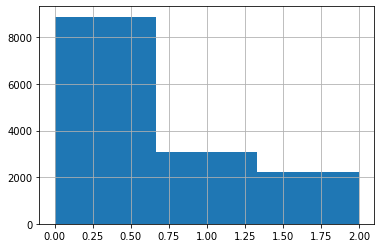

In [39]:
#df_interp.loc[:,'label_thresh_rest10'].hist(bins=3)

## Preprocessing
Run the following cell to generate the folder for the Torch ImageLoader class.
The cell requires a labels.csv file which contains the filenames 
of the image files and corresponding resistivity labels (which can be extended
from binary to multiclass depending on resistivity threshold)

In [ ]:
with open('/datadrive/labels.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        print(row)
        img_name = row[1]
        label = row[2]#int(row[2]=='True')
        month_folder = row[0][:10]
        #print(month_folder)
        #print(img_name,label)
        #print(os.path.join(img_folder,month_folder,img_name))
        if YEAR_FLAG == 'train':
            shutil.copyfile(os.path.join(img_folder,month_folder,img_name),os.path.join(target_folder_train,label,img_name))
        else:
            shutil.copyfile(os.path.join(img_folder,month_folder,img_name),os.path.join(target_folder_test,label,img_name))
